Using device: cuda
Training Improved MDN...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  1: Train Loss = -344.2735, Val Loss = -808.2726, LR = 2.00e-03
Epoch  6: Train Loss = -2642.1777, Val Loss = -2551.8314, LR = 2.00e-03
Epoch 11: Train Loss = -1831.4153, Val Loss = -1866.5753, LR = 1.40e-03
Epoch 16: Train Loss = -1373.9699, Val Loss = -1591.8254, LR = 9.80e-04
Epoch 21: Train Loss = -1337.5923, Val Loss = -1504.8016, LR = 4.80e-04
Reconstruction Results:


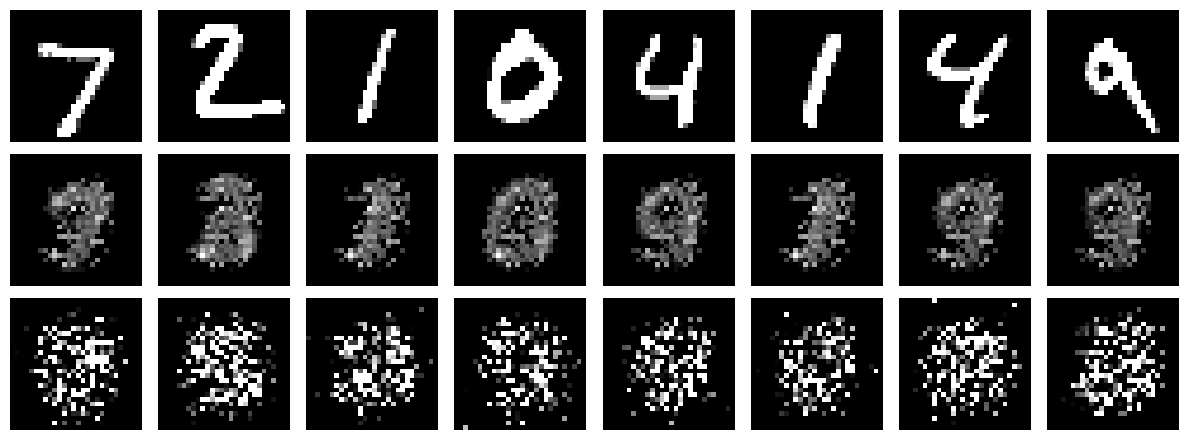

Sampling Method Comparison:


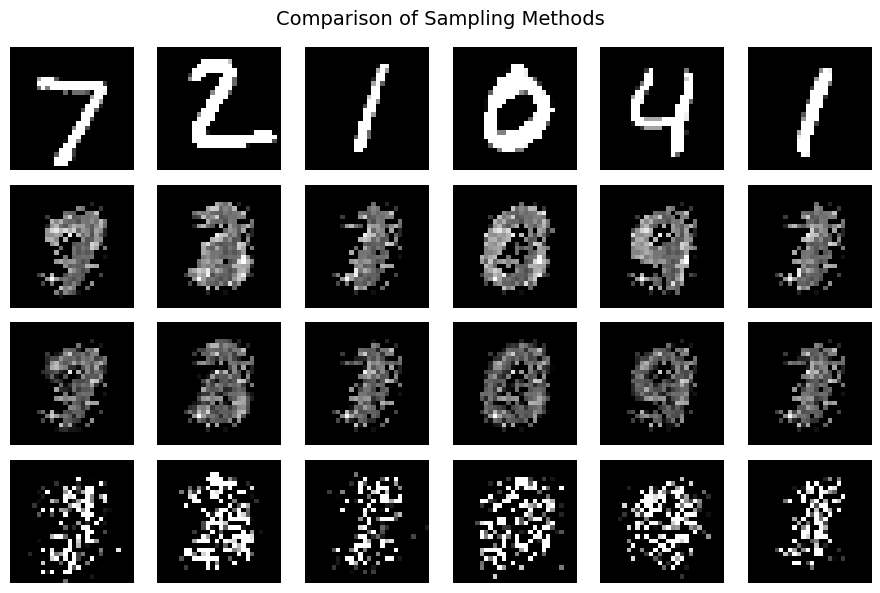

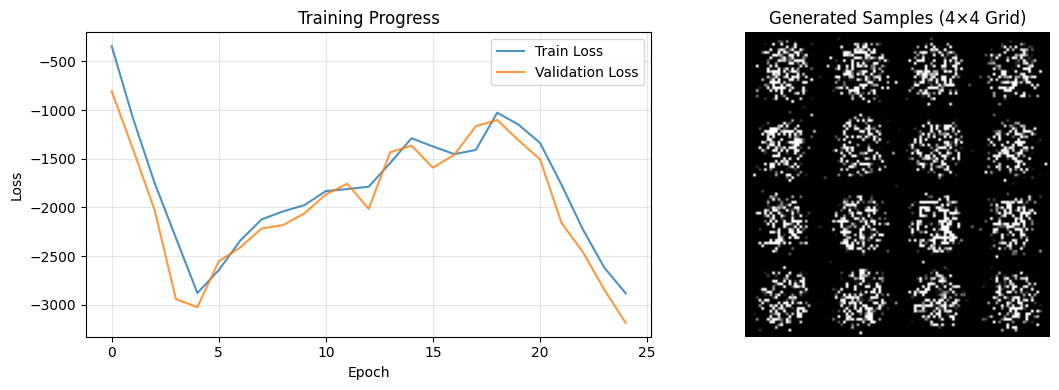


Final Results:
Test Loss: -3206.9460
Model Parameters: 2,134,512
Mixture Components: 5

Model Architecture:
- Input: 784 pixels (28×28 MNIST)
- Hidden layers: [512, 256, 128]
- Mixture components: 5
- Output: 3 parameters per pixel per component (π, μ, σ)
- Total parameters: 2,134,512


In [5]:
# Improved Mixture Density Network (MDN) implementation on MNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Enhanced Dataset Preparation ---

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean/std
])

# Load full dataset with train/val split
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# Test dataset for final evaluation
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# --- 2. Improved Mixture Density Network ---

class ImprovedMDN(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[512, 256, 128], n_components=5, dropout=0.2):
        super().__init__()
        self.n_components = n_components
        self.input_dim = input_dim

        # Build encoder backbone
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        self.backbone = nn.Sequential(*layers)

        # Mixture parameter heads with separate networks
        self.pi_head = nn.Sequential(
            nn.Linear(prev_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, input_dim * n_components)
        )

        self.mu_head = nn.Sequential(
            nn.Linear(prev_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, input_dim * n_components)
        )

        self.sigma_head = nn.Sequential(
            nn.Linear(prev_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, input_dim * n_components)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size = x.size(0)
        h = self.backbone(x)

        # Mixture weights (sum to 1 for each pixel)
        pi_logits = self.pi_head(h).view(batch_size, self.input_dim, self.n_components)
        pi = F.softmax(pi_logits, dim=-1)

        # Means (can be any real value)
        mu = self.mu_head(h).view(batch_size, self.input_dim, self.n_components)

        # Standard deviations (must be positive)
        log_sigma = self.sigma_head(h).view(batch_size, self.input_dim, self.n_components)
        log_sigma = torch.clamp(log_sigma, min=-10.0, max=5.0)  # Better stability
        sigma = torch.exp(log_sigma) + 1e-6  # Add small epsilon for numerical stability

        return pi, mu, sigma

# --- 3. Enhanced Loss Function with Better Numerical Stability ---

def stable_mdn_loss(y, pi, mu, sigma, temperature=1.0):
    """
    Numerically stable MDN loss using log-sum-exp trick
    """
    y_expanded = y.unsqueeze(-1)  # [batch, input_dim, 1]

    # Compute log probabilities for numerical stability
    log_2pi = np.log(2.0 * np.pi)
    log_prob = -0.5 * (log_2pi + 2 * torch.log(sigma) +
                      ((y_expanded - mu) / sigma) ** 2)

    # Add mixture weights in log space
    log_pi = torch.log(pi + 1e-8)
    log_weighted = log_pi + log_prob

    # Use log-sum-exp for numerical stability
    log_sum = torch.logsumexp(log_weighted / temperature, dim=-1)

    # Negative log-likelihood
    nll = -log_sum.sum(dim=-1).mean()
    return nll

# --- 4. Improved Sampling Functions ---

def sample_from_mixture(pi, mu, sigma, method='sample'):
    """
    Multiple sampling strategies from mixture
    """
    batch_size, input_dim, n_components = pi.shape

    if method == 'mode':
        # Use most likely component for each pixel
        best_components = torch.argmax(pi, dim=-1)  # [batch, input_dim]
        batch_idx = torch.arange(batch_size).unsqueeze(1)
        pixel_idx = torch.arange(input_dim).unsqueeze(0)
        selected_mu = mu[batch_idx, pixel_idx, best_components]
        return selected_mu

    elif method == 'weighted_mean':
        # Weighted average of all components
        weighted_mu = (pi * mu).sum(dim=-1)
        return weighted_mu

    else:  # 'sample'
        # Stochastic sampling
        categorical = torch.distributions.Categorical(pi)
        component_indices = categorical.sample()  # [batch, input_dim]

        # Gather selected parameters
        batch_idx = torch.arange(batch_size).unsqueeze(1)
        pixel_idx = torch.arange(input_dim).unsqueeze(0)
        selected_mu = mu[batch_idx, pixel_idx, component_indices]
        selected_sigma = sigma[batch_idx, pixel_idx, component_indices]

        # Sample from selected Gaussians
        noise = torch.randn_like(selected_mu)
        samples = selected_mu + selected_sigma * noise
        return samples

def generate_new_samples(model, n_samples=16, method='sample'):
    """Generate completely new samples using random inputs"""
    model.eval()
    with torch.no_grad():
        # Use random noise as input to generate diverse outputs
        random_input = torch.randn(n_samples, 784).to(next(model.parameters()).device)
        pi, mu, sigma = model(random_input)
        samples = sample_from_mixture(pi, mu, sigma, method)
        return torch.clamp(samples, 0, 1)  # Clamp to valid pixel range

# --- 5. Training Setup with Learning Rate Scheduling ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ImprovedMDN(
    input_dim=784,
    hidden_dims=[512, 256, 128],
    n_components=5,
    dropout=0.3
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=3, verbose=True
)

# --- 6. Enhanced Training Loop with Validation ---

def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(-1, 784).to(device)
            pi, mu, sigma = model(x)
            loss = stable_mdn_loss(x, pi, mu, sigma)
            total_loss += loss.item()
    return total_loss / len(data_loader)

print("Training Improved MDN...")
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(25):
    # Training
    model.train()
    total_train_loss = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(x)
        loss = stable_mdn_loss(x, pi, mu, sigma)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_train_loss += loss.item()

    # Validation
    val_loss = evaluate_model(model, val_loader)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_mdn_model.pth')

    # Logging
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1:2d}: Train Loss = {avg_train_loss:.4f}, "
              f"Val Loss = {val_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.2e}")

# Load best model for evaluation
model.load_state_dict(torch.load('best_mdn_model.pth'))

# --- 7. Comprehensive Evaluation and Visualization ---

def show_comparison(original, reconstructed, generated, n_show=8):
    """Show original, reconstructed, and generated images"""
    fig, axes = plt.subplots(3, n_show, figsize=(n_show*1.5, 4.5))

    titles = ['Original', 'Reconstructed', 'Generated']
    images = [original, reconstructed, generated]

    for row, (title, imgs) in enumerate(zip(titles, images)):
        for col in range(n_show):
            if col < len(imgs):
                img = imgs[col].reshape(28, 28).cpu().numpy()
                axes[row, col].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(title, fontsize=12)

    plt.tight_layout()
    plt.show()

def compare_sampling_methods(model, test_input, n_show=6):
    """Compare different sampling methods"""
    model.eval()
    with torch.no_grad():
        pi, mu, sigma = model(test_input)

        mode_samples = sample_from_mixture(pi, mu, sigma, 'mode')
        mean_samples = sample_from_mixture(pi, mu, sigma, 'weighted_mean')
        stoch_samples = sample_from_mixture(pi, mu, sigma, 'sample')

    fig, axes = plt.subplots(4, n_show, figsize=(n_show*1.5, 6))

    methods = ['Original', 'Mode', 'Weighted Mean', 'Stochastic']
    samples = [test_input, mode_samples, mean_samples, stoch_samples]

    for row, (method, imgs) in enumerate(zip(methods, samples)):
        for col in range(n_show):
            img = imgs[col].reshape(28, 28).cpu().numpy()
            img = np.clip(img, 0, 1)  # Ensure valid range
            axes[row, col].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(method, fontsize=10)

    plt.suptitle('Comparison of Sampling Methods', fontsize=14)
    plt.tight_layout()
    plt.show()

# Get test samples
model.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_input = test_batch[:8].view(-1, 784).to(device)

    # Reconstruct using the model
    pi, mu, sigma = model(test_input)
    reconstructed = sample_from_mixture(pi, mu, sigma, 'weighted_mean')

    # Generate new samples
    generated = generate_new_samples(model, n_samples=8, method='sample')

# --- 8. Visualizations ---

# Show reconstruction results
print("Reconstruction Results:")
show_comparison(test_input, reconstructed, generated)

# Compare sampling methods
print("Sampling Method Comparison:")
compare_sampling_methods(model, test_input)

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show generated samples grid
generated_grid = generate_new_samples(model, n_samples=16, method='sample')
grid_img = torch.zeros(4*28, 4*28)
for i in range(16):
    row, col = i // 4, i % 4
    grid_img[row*28:(row+1)*28, col*28:(col+1)*28] = generated_grid[i].reshape(28, 28).cpu()

plt.imshow(grid_img, cmap='gray', vmin=0, vmax=1)
plt.title('Generated Samples (4×4 Grid)')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- 9. Final Evaluation ---

test_loss = evaluate_model(model, test_loader)
print(f"\nFinal Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Mixture Components: {model.n_components}")

# Show model architecture summary
print(f"\nModel Architecture:")
print(f"- Input: 784 pixels (28×28 MNIST)")
print(f"- Hidden layers: {[512, 256, 128]}")
print(f"- Mixture components: {model.n_components}")
print(f"- Output: 3 parameters per pixel per component (π, μ, σ)")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")